# Hydroelastic Contact: Non-convex compliant meshes
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

If you are not familiar with Drake's hydroelastic contact model, first study [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb). You can also find more information in Hydroelastic Contact User Guide [here.](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

### Visual geometries
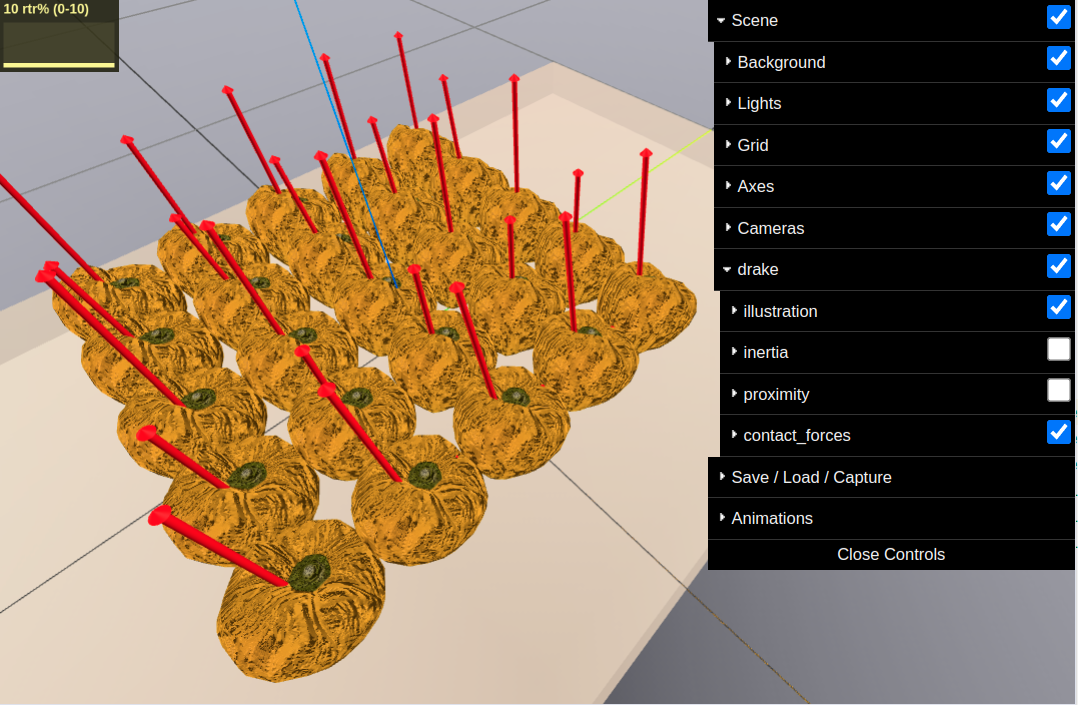

### Collision geometries
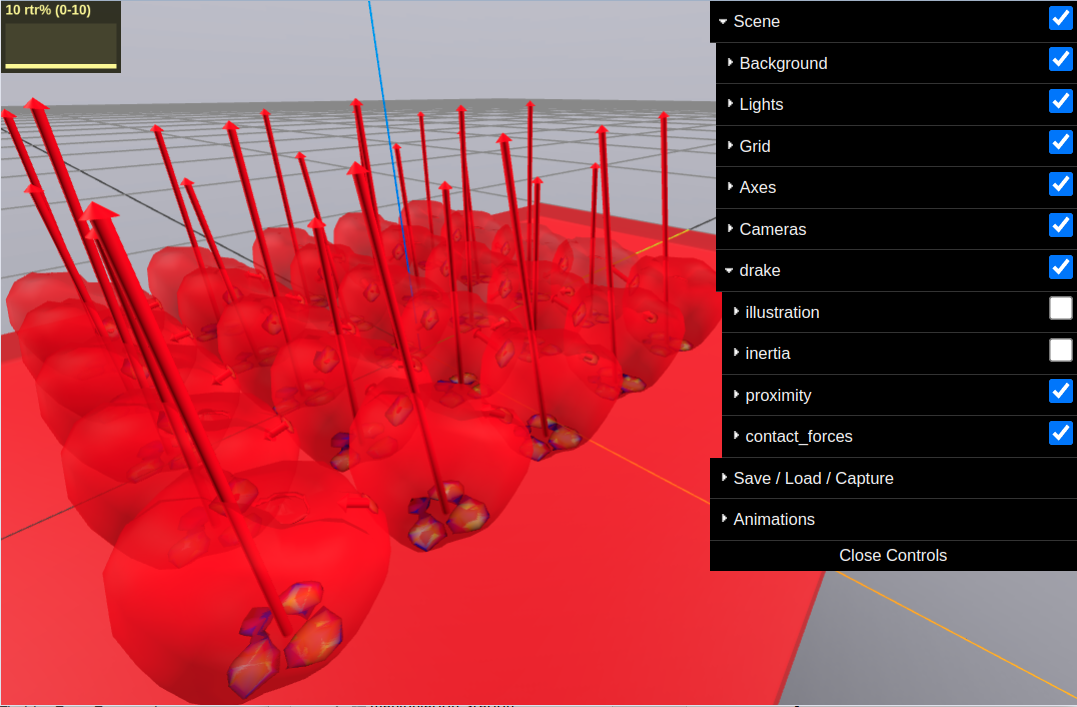

## Start MeshCat

See the section [Viewing models](./authoring_multibody_simulation.ipynb#Viewing-models) in the tutorial [Authoring a Multibody Simulation](./authoring_multibody_simulation.ipynb) for an introduction to MeshCat.

In [1]:
from pydrake.geometry import StartMeshcat

# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Create compliant-hydroelastic mesh of a bell pepper

*Make sure you have the MeshCat tab opened in your browser;
the link is shown immediately above.*


In [2]:
from pydrake.visualization import ModelVisualizer

# Create model with name: yellow_pepper_{number}
def yellow_pepper(number='0'):
    return f"""<?xml version="1.0"?>
    <sdf version="1.7" xmlns:drake="drake.mit.edu">
      <model name="yellow_pepper_{number}">
        <link name="yellow_pepper_{number}">
          <pose>0 0 0 0 0 0</pose>
          <inertial>
            <pose>0.000537 -0.00272 0.0384 0 0 0</pose>
            <mass>0.159</mass>
            <inertia>
              <ixx> 0.000101</ixx>
              <ixy>-0.000001</ixy>
              <ixz>-0.000004</ixz>
              <iyy> 0.000105</iyy>
              <iyz> 0.000007</iyz>
              <izz> 0.000107</izz>
            </inertia>
          </inertial>
          <visual name="yellow_bell_pepper_no_stem">
            <pose>0 0 0 0 0 0</pose>
            <geometry>
              <mesh>
                <uri>package://drake_models/veggies/yellow_bell_pepper_no_stem_low.obj</uri>
                <scale>1 1 1</scale>
              </mesh>
            </geometry>
          </visual>
          <collision name="collision">
            <pose>0 0 0 0 0 0</pose>
            <geometry>
              <mesh>
                <uri>package://drake_models/veggies/yellow_bell_pepper_no_stem_low.vtk</uri>
                <scale>1 1 1</scale>
              </mesh>
            </geometry>
            <drake:proximity_properties>
              <drake:compliant_hydroelastic/>
              <drake:hydroelastic_modulus>5.0e4</drake:hydroelastic_modulus>
              <!-- Most shapes (capsule, cylinder, ellipsoid, sphere) need
                drake:mesh_resolution_hint, but the resolution hint is no-op
                for the mesh geometry. That's why we do not set it here. -->
              <drake:hunt_crossley_dissipation>10</drake:hunt_crossley_dissipation>
              <!-- Both mu_dynamic and mu_static are used in Continuous system.
                Only mu_dynamic is used in Discrete system.  -->
              <drake:mu_dynamic> 1 </drake:mu_dynamic>
              <drake:mu_static> 1 </drake:mu_static>
            </drake:proximity_properties>
          </collision>
        </link>
        <frame name="origin">
          <pose relative_to="yellow_pepper_{number}">0 0 0 0 0 0</pose>
        </frame>
        <frame name="flush_bottom_center__z_up">
          <pose relative_to="yellow_pepper_{number}">0 0 0 0 0 0</pose>
        </frame>
      </model>
    </sdf>
    """

pepper0 = yellow_pepper('0')

visualizer = ModelVisualizer(meshcat=meshcat, visualize_frames=True)
visualizer.parser().AddModelsFromString(pepper0, "sdf")
visualizer.Run(loop_once=True)

## Create rigid-hydroelastic box

The following SDFormat string specifies a rigid-hydroelastic box. It is similar to the compliant-hydroelastic box.

Both the `<visual>` and `<collision>` geometries are boxes of size 60cm x 1m x 5cm. Observe in MeshCat the X(red), Y(green), and Z(blue) axes.

Use the tag `<drake:rigid_hydroelastic/>` to specify a rigid-hydroelastic geometry. It does not use `<drake:hydroelastic_modulus>`. Intuitively it has infinite hydroelastic modulus.

This rigid-hydroelastic box uses the same friction coefficient and dissipation constants as the previous compliant-hydroelastic box.

We do not specify `<mass>` and `<inertia>` of the rigid box because, in the next section when we set up `Diagram`, we will fix the rigid box to the world frame. It will not move.

The `<frame name="top_surface">` is a frame at the top of the box with the tag:

    <pose relative_to="rigid_box_link">0 0 0.025 0 0 0</pose>

It is at 2.5cm (half of the box's height) above the center of the box. In the next section, we will create a scene that places the `top_surface` frame at the world's origin.

In [3]:
from pydrake.visualization import ModelVisualizer

# Create a rigid-hydroelastic table top
rigid_box_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="RigidBox">
    <link name="rigid_box_link">
      <visual name="visual">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>0.6 1.0 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 0.5</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0 0 0 0</pose>
        <geometry>
          <box>
            <size>0.6 1.0 0.05</size>
          </box>
        </geometry>
        <drake:proximity_properties>
          <drake:rigid_hydroelastic/>
          <drake:mu_dynamic>0.5</drake:mu_dynamic>
          <drake:hunt_crossley_dissipation>1.25</drake:hunt_crossley_dissipation>
          <drake:relaxation_time>0.1</drake:relaxation_time>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="top_surface">
      <pose relative_to="rigid_box_link">0 0 0.025 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

# Visualize the SDFormat string you just defined.
visualizer = ModelVisualizer(meshcat=meshcat, visualize_frames=True)
visualizer.parser().AddModelsFromString(rigid_box_sdf, "sdf")
visualizer.Run(loop_once=True)

## Create Diagram of the scene

The function `add_scene()` below creates a scene using the geometries that we created.

It uses `DiagramBuilder` to create `MultibodyPlant` and `SceneGraph`. It uses `Parser` to add the SDFormat strings of the geometries into `Diagram` of the scene.

It fixes the rigid box's top surface to the world frame by calling `WeldFrames()`.

It places a number of bell peppers above the rigid box.

After this step, the next section will add visualization to `DiagramBuilder`.

In [4]:
from pydrake.math import RigidTransform
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlant, MultibodyPlantConfig
from pydrake.systems.framework import DiagramBuilder

def clear_meshcat():
    # Clear MeshCat window from the previous blocks.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

def add_scene(grid_size=3, time_step=1e-2, solver="sap"):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlant(
        MultibodyPlantConfig(
            time_step=time_step,
            discrete_contact_solver=solver),
        builder)
    parser = Parser(plant)

    # Load the bell peppers and the table-top box.
    # The number of bell peppers is the squared grid_size.
    # grid_size  number_of_peppers
    #     1             1         
    #     2             4         
    #     3             9         
    #     4            16         
    #     5            25         
    for i in range(grid_size):
        for j in range(grid_size):
            parser.AddModelsFromString(yellow_pepper(f"{i}{j}"), "sdf")
    parser.AddModelsFromString(rigid_box_sdf, "sdf")

    # Weld the rigid box to the world so that it's fixed during simulation.
    # The top surface passes the world's origin.
    plant.WeldFrames(plant.world_frame(), 
                     plant.GetFrameByName("top_surface"))

    # Finalize the plant after loading the scene.
    plant.Finalize()

    # Set how high the bottom of the yellow bell pepper is from the world's origin. 
    for i in range(grid_size):
        for j in range(grid_size):
            plant.SetDefaultFreeBodyPose(
                plant.GetBodyByName(f"yellow_pepper_{i}{j}"),
                RigidTransform(p=[-0.15 + 0.07 * i, -0.15 + 0.07 * j, 0.20]))


    return builder, plant

## Set up visualization of the simulation

The function `add_scene()` above does not have visualization, so we will do it in the function `add_viz()` below.

It uses `DiagramBuilder` from `add_scene()`. The `meshcat` interface represents the same MeshCat window that we have been using.

We set the `publish_period` to 1/16 to publish 16 frames per simulated second. See documentation of [VisualizationConfig](https://drake.mit.edu/doxygen_cxx/structdrake_1_1visualization_1_1_visualization_config.html) for more details.

At this step we set `publish_contacts` to `False`, we will set up contact visualization near the end of this tutorial.

We test the creation of `Diagram` by simulating for 0 second. It shows the initial condition.

In [5]:
from pydrake.visualization import ApplyVisualizationConfig, VisualizationConfig

def add_viz(builder, plant):
    ApplyVisualizationConfig(
        config=VisualizationConfig(
                   publish_period = 1 / 16.0,
                   publish_contacts = False),
        builder=builder, meshcat=meshcat)
    
    return builder, plant


from pydrake.systems.analysis import Simulator

# Test creation of the diagram by simulating for 0 second.
# For now, use only the DiagramBuilder from the first return value and
# ignore the other return value. We will use it later.
clear_meshcat()
builder, plant = add_scene(grid_size=2)
add_viz(builder, plant)
simulator = Simulator(builder.Build())
simulator.Initialize()
simulator.AdvanceTo(0)

print(simulator.get_actual_realtime_rate())

0.0


### Run the simulation

We define the function `run_simulation()` below. It builds `Diagram` using `DiagramBuilder` from the previous step. It passes `Diagram` to `Simulator`.You should see the bell peppers drop down to make contact with the rigid box.

In [6]:
from pydrake.systems.analysis import Simulator

def run_simulation(sim_time):
    clear_meshcat()
    
    # grid_size  number_of_peppers   real_time_rate
    #     1             1            380%
    #     2             4             50%
    #     3             9             16%
    #     4            16              7%
    #     5            25              4%
    builder, plant = add_scene(grid_size=5)
    add_viz(builder, plant)
    
    diagram = builder.Build()
    
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(0)
    
    simulator.AdvanceTo(sim_time)
    
    print(simulator.get_actual_realtime_rate())

run_simulation(sim_time=1)

0.039616994566116705


## Visualize contact results

To visualize contact results, we will add `ContactVisualizer` to `Diagram` of the previous section.

The following function `add_contact_viz()` adds `ContactVisualizer` to `DiagramBuilder` using `MultibodyPlant` and `Meshcat`.

With `newtons_per_meter= 2e1`, it will draw a red arrow of length 1 meter for each force of 20 newtons. With `newtons_meters_per_meter= 1e-1`, it will draw a blue arrow of length 1 meter for each torque of 0.1 newton\*meters. The next section will run the simulation.

In [7]:
from pydrake.multibody.meshcat import ContactVisualizer, ContactVisualizerParams


def add_contact_viz(builder, plant):
    contact_viz = ContactVisualizer.AddToBuilder(
        builder, plant, meshcat,
        ContactVisualizerParams(
            publish_period= 1.0 / 8.0,
            newtons_per_meter= 10,
            newton_meters_per_meter= 1e-1))

    return builder, plant

### Run simulation with contact visualization

The following code will run the simulation. In MeshCat, the red arrow represents the force `f`, and the blue arrow represents the torque `tau`. You should see the contact patch moving around together with the force and torque vectors. At the end of simulation, it will also report contact result numerically.

In [8]:
from pydrake.systems.analysis import Simulator

def run_simulation_with_contact_viz(sim_time):
    clear_meshcat()
            
    # grid_size  number_of_peppers   real_time_rate
    #     1             1            360%
    #     2             4             50%
    #     3             9             16%
    #     4            16              7%
    #     5            25              4%
    builder, plant = add_scene(grid_size=5)
    add_viz(builder, plant)
    add_contact_viz(builder, plant)
    
    diagram = builder.Build()
    
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(0.0)
    
    simulator.AdvanceTo(sim_time)
    
    print(simulator.get_actual_realtime_rate())
    
run_simulation_with_contact_viz(sim_time=1)

0.03980382568285036


## Further reading

* [Hydroelastic Contact User Guide](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

* Elandt, R., Drumwright, E., Sherman, M., & Ruina, A. (2019, November). A pressure field model for fast, robust approximation of net contact force and moment between nominally rigid objects. In 2019 IEEE/RSJ International Conference on Intelligent Robots and Systems(IROS) (pp. 8238-8245). IEEE. [link](https://arxiv.org/abs/1904.11433)

* Masterjohn, J., Guoy, D., Shepherd, J., & Castro, A. (2022). Velocity Level Approximation of Pressure Field Contact Patches. IEEE Robotics and Automation Letters 7, no. 4 (2022): 11593-11600. [link](https://arxiv.org/abs/2110.04157v2)

* Elandt, R. (2022, December). Pressure Field Contact. Dissertation. Cornell University. [link](https://ecommons.cornell.edu/handle/1813/112919)